In [1]:
include("cumulant.jl")

decay (generic function with 1 method)

In [2]:
bath=overdampedBath(1.0,0.05,5.0);

In [4]:
x=LinRange(0,10,100);

In [5]:
using QuantumToolbox 

In [6]:
Hsys=sigmaz()/2

Quantum Object:   type=Operator   dims=[2]   size=(2, 2)   ishermitian=true
2×2 SparseMatrixCSC{ComplexF64, Int64} with 2 stored entries:
 0.5+0.0im       ⋅    
     ⋅      -0.5+0.0im

In [7]:
function eigvects_to_kets(vects) #Maybe this is unnecessary
    return [Qobj(vects[:,i]) for i in 1:size(vects)[1]]
end

eigvects_to_kets (generic function with 1 method)

# I have a problem to change basis with quantum toolbox, The eigvects are not kets or it looks like it

In [8]:
function jump_operators(Hsys,Q)
    eigvals,eigvects=eigen(Hsys);
    eigvects=eigvects_to_kets(eigvects);
    N=length(eigvals);
    collapse = []
    ws= []
    for j=1:N
        for k=j:N
            gap=eigvals[k] - eigvals[j]
            if  !isapprox(gap,0.0) #dephasing
                push!(ws,gap)
                push!(collapse,(eigvects[j]*eigvects[j]')*Q*(eigvects[k]*eigvects[k]'))
                push!(ws,-gap)
                push!(collapse,eigvects[k]*eigvects[k]'*Q*eigvects[j]*eigvects[j]')
            end
        end
    end
    push!(collapse,Q-sum(collapse))
    push!(ws,0)# dephasing
    for i in eachindex(collapse)
        if collapse[i]==Qobj(Hsys)*0
            deleteat!(ws,i)
            deleteat!(collapse,i)
        end
    end
    jump=Dict(ws .=> collapse)
    return ws,jump
end

jump_operators (generic function with 1 method)

In [9]:
using IterTools

In [10]:
function decays(Hsys,Q,bath,t)
    ws,jump=jump_operators(Hsys,Q)
    combinations=collect(product(ws,ws))
    rates=Dict()
    for i in eachindex(combinations)
        j=combinations[i]
        rates[j]=decay.(j[1],j[2],bath,t) 
    end
    return rates
end

decays (generic function with 1 method)

In [11]:
function cum_superop(Hsys,Q)
    ws,jump=jump_operators(Hsys,Q)
    combinations=collect(product(ws,ws))
    superops=Dict()
    for i in eachindex(combinations)
        j=combinations[i]
        superops[j]=spre(jump[j[2]])*spost(jump[j[1]]') - 0.5*(spre(jump[j[1]]' *jump[j[2]])+spost(jump[j[1]]' *jump[j[2]]))
    end
    return superops
end

cum_superop (generic function with 1 method)

In [12]:
function generator(Hsys,Q,bath,t)
    dict=decays(Hsys,Q,bath,t)#fine;
    dict2=cum_superop(Hsys,Q)#fine;
    ans=[0.0*Qobj(spre(Q)) for j in 1:length(t) ]
    for i in collect(keys(dict))
        ans +=[j *dict2[i] for j in dict[i]]
    end
    return ans
end

generator (generic function with 1 method)

In [13]:
ans=generator(sigmaz()/2,sigmax(),bath,x)[10]

Quantum Object:   type=SuperOperator   dims=[2]   size=(4, 4)
4×4 Matrix{ComplexF64}:
 -0.155896+0.0im        0.0+0.0im        …   0.0912865+0.0im
       0.0+0.0im  -0.123591+0.0im                  0.0+0.0im
       0.0+0.0im  0.0659057+0.0846202im            0.0+0.0im
  0.155896+0.0im        0.0+0.0im           -0.0912865+0.0im

In [35]:
function csolve(Hsys,Q,bath,t,rho0)
    g=generator(Hsys,Q,bath,t)
    return [Qobj(vec2mat(exp(i).data * mat2vec(rho0.data))) for i in g]
end

csolve (generic function with 1 method)

In [36]:
states=csolve(sigmaz()/2,sigmax(),bath,x,rho0);

In [37]:
using CairoMakie

In [44]:
sz=[expect(states[i],(1+sigmaz())/2) for i in 1:length(states)];

In [46]:
CairoMakie.activate!()

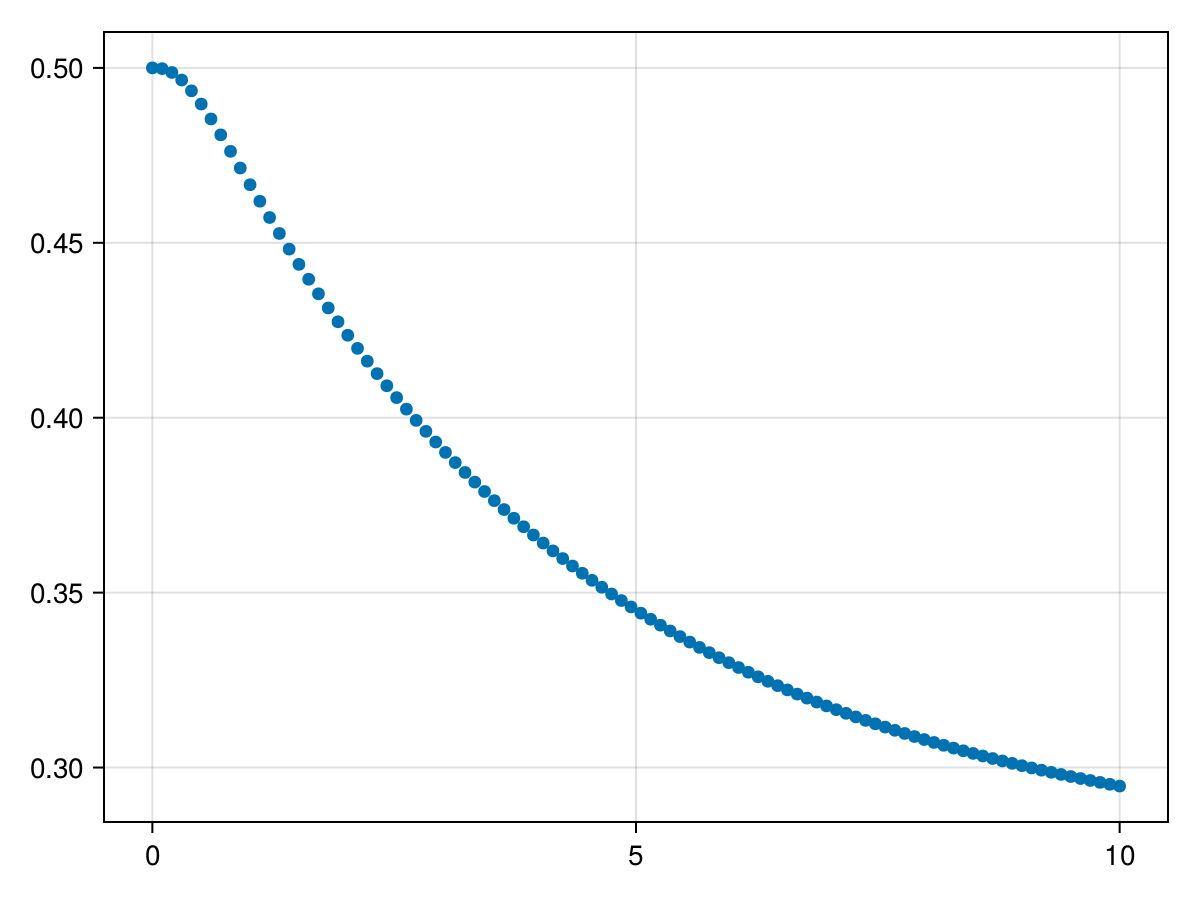

In [53]:
fig=plot(x,Float32.(sz))

In [33]:
# CHECK https://github.com/SciML/ExponentialUtilities.jl